In [35]:
# from comet_ml import Experiment

# Run your code and go to /

import torch
t = torch
from torch import nn, optim
import matplotlib.pyplot as plt

import gin
from PIL import Image
import requests
import torchvision
tv = torchvision
from torchvision import transforms
import einops

In [36]:
# img_data = requests.get("https://d1iczm3wxxz9zd.cloudfront.net/971e55cc-128e-4809-bb05-2adf7b0238ec/000000-0000000000/39127110424036069919666352160427857710300904072429089980813045768686488932997/ITEM_PREVIEW1.jpg").content
# with open('pineapple.jpg', 'wb') as handler:
#     handler.write(img_data)

In [61]:
def imshow(img, figsize=(6, 6)):
    # img is three or four dimensional with size-1 dim 0
    img = torch.Tensor(img)
    if img.requires_grad:
        img = img.detach()
    plt.figure(figsize=figsize)
    if len(img.size()) == 4:
        im = img[0]
    else:
        im = img
    if im.size()[0] == 3:
        im = einops.rearrange(im, 'a b c->b c a')
    plt.imshow(im)

torch.Size([3, 1920, 1920])


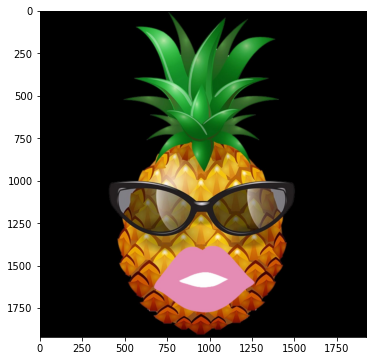

In [38]:
im = Image.open('pineapple.jpg')
im_tensor = transforms.ToTensor()(im)
print(im_tensor.size())
imshow(im_tensor)

In [66]:
resnet = torchvision.models.resnet34(pretrained=True)
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [144]:
from tqdm import tqdm

class ImageModule(t.nn.Module):

    def __init__(self, decorrelated = True):
        super().__init__()
        self.decorrelated = decorrelated
        if decorrelated:
            self.register_buffer('changeofbasis', t.tensor(
                [[ 0.56282854, 0.19482528, 0.0432945 ],
                [ 0.5844758,  0.   ,     -0.10823626],
                [ 0.5844758, -0.19482528, 0.06494176]]
            ))

        # self.img =  nn.Parameter(t.rand((1,3,224,244)))
        self.img =  nn.Parameter(t.randn((1,3,224,244)))

        self.transform = nn.Sequential(
            transforms.ColorJitter(.02, .02, .02, .02),
            transforms.RandomAffine(10, translate=(1/10,1/10), scale=(.9,1.1))
        )



    def forward(self, transform=False):
        if self.decorrelated:
            img = t.einsum('ic, bchw -> bihw', self.changeofbasis, img)
        img = t.sigmoid(self.img)
        img = self.transform(img) if transform else img
        return img

    def show_img(self):
        imshow(self.forward(transform=False).cpu())


class ImageFourierModule(t.nn.Module):

    def __init__(self, decorrelated = True):
        super().__init__()
        self.decorrelated = decorrelated
        if decorrelated:
            self.register_buffer('changeofbasis', t.tensor(
                [[ 0.56282854, 0.19482528, 0.0432945 ],
                [ 0.5844758,  0.   ,     -0.10823626],
                [ 0.5844758, -0.19482528, 0.06494176]]
            ))

        # self.img =  nn.Parameter(t.rand((1,3,224,244)))
        self.freq_params =  nn.Parameter(100*t.randn((1,3,224,112, 2)))


        self.transform = nn.Sequential(
            transforms.ColorJitter(.02, .02, .02, .02),
            transforms.RandomAffine(10, translate=(1/10,1/10), scale=(.9,1.1))
        )

        fy = einops.repeat(torch.fft.fftfreq(224), 'c -> a b c d e', a=1, b = 3, d = 112, e = 2)
        fx = einops.repeat(torch.fft.fftfreq(112), 'd -> a b c d e', a=1, b = 3, c = 224, e = 2)
        frequency_mult = 1/t.sqrt(fy**2+fx**2)
        frequency_mult[:, :, 0, 0, :] = 224

        self.register_buffer('frequency_mult', frequency_mult)
        # self.frequency_mult.to('cuda')


    def forward(self, transform=False):
        img = t.fft.irfft2(torch.view_as_complex(self.freq_params*self.frequency_mult))
        if self.decorrelated:
            img = t.einsum('ic, bchw -> bihw', self.changeofbasis, img)
        img = t.sigmoid(img)
        img = self.transform(img) if transform else img
        return img

    def show_img(self):
        imshow(self.forward(transform=False).cpu())


img = ImageFourierModule()
img.to("cuda")
resnet.to("cuda")

def optimize_image(img, epochs, lr=0.05):
    optimizer = torch.optim.Adam(img.parameters(), lr=lr)
    pbar = tqdm(range(epochs))
    for i in pbar:
        optimizer.zero_grad()
        out = resnet(img(True))[0,50]
        loss = -out
        loss.backward()
        if i % 10 == 0:
            pbar.set_description(f'loss={loss.item():.2}')
        optimizer.step()


# out = model(img.get_img().reshape((1,)+img.get_img().shape))

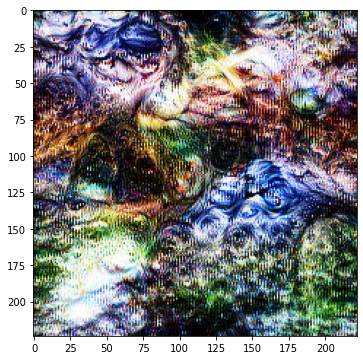

loss=-9e+01: 100%|██████████| 1000/1000 [00:25<00:00, 39.17it/s] 


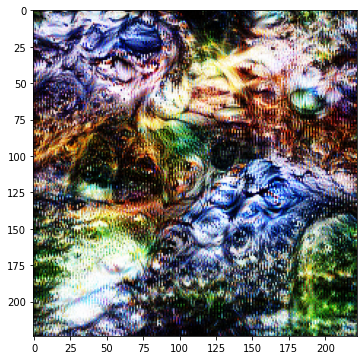

In [146]:
img.show_img()
plt.show()

optimize_image(img, 1000, lr=.5)

img.show_img()

In [189]:
from collections import OrderedDict

outputs = [0 for _ in range(4)]

def get_forwardhook(layer):
    def ourforwardhook(module, input, output):
        # print('input', input[0].shape, input[1:])
        # print('output', output.shape)
        outputs[layer] = output
    return ourforwardhook

# resnet.conv1.register_forward_hook(ourforwardhook)

def remove_hooks(module):
    module._forward_hooks = OrderedDict()


layers = [resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4]

remove_hooks(resnet)
remove_hooks(resnet.conv1)
for i, layer in enumerate(layers):
    # print(layer._forward_hooks)
    remove_hooks(layer)
    # print(layer._forward_hooks)
    layer.register_forward_hook(get_forwardhook(i))

# print([m for m in resnet.modules()])

def optimize_image(img, epochs, lr=0.05, layer = 0):
    optimizer = torch.optim.Adam(img.parameters(), lr=lr)
    pbar = tqdm(range(epochs))
    for i in pbar:
        optimizer.zero_grad()
        _ = resnet(img(True))
        loss = -t.sum(outputs[layer][0, 0]**2)
        loss.backward()
        if i % 10 == 0:
            pbar.set_description(f'loss={loss.item():.2}')
        optimizer.step()


ImageFourierModule(
  (transform): Sequential(
    (0): ColorJitter(brightness=[0.98, 1.02], contrast=[0.98, 1.02], saturation=[0.98, 1.02], hue=[-0.02, 0.02])
    (1): RandomAffine(degrees=[-10.0, 10.0], translate=(0.1, 0.1), scale=(0.9, 1.1))
  )
)

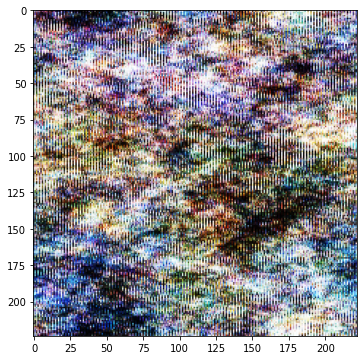

loss=-4.6e+02: 100%|██████████| 1000/1000 [00:24<00:00, 41.45it/s]


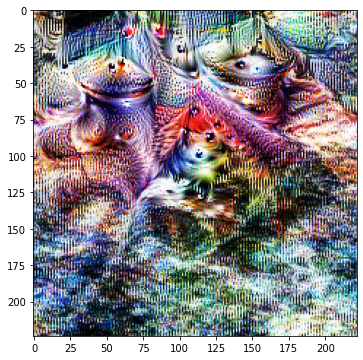

In [193]:

img =ImageFourierModule() 
img.to('cuda')
img.show_img()
plt.show()
optimize_image(img, 1000, layer = 2, lr=0.5)
img.show_img()